# Physics based pedestrian modeling

<p align="center">
    <a href="https://github.com/c-pouw/physics-based-pedestrian-modeling/" alt="Repository">
	   <img src="https://img.shields.io/badge/GitHub-181717?style=flat&logo=github&logoColor=white" /></a>
	<a href="https://github.com/c-pouw/physics-based-pedestrian-modeling/actions/workflows/integration-tests.yaml" alt="Integration Tests">
	   <img src="https://github.com/c-pouw/physics-based-pedestrian-modeling/actions/workflows/integration-tests.yaml/badge.svg" /></a>
    <a href="https://c-pouw.github.io/physics-based-pedestrian-modeling" alt="docs">
	   <img src="https://github.com/c-pouw/physics-based-pedestrian-modeling/actions/workflows/docs.yml/badge.svg" /></a>
    <a href="https://c-pouw.github.io/physics-based-pedestrian-modeling/reports/junit/report.html?sort=result">
	   <img src="https://c-pouw.github.io/physics-based-pedestrian-modeling/reports/junit/tests-badge.svg?dummy=8484744" alt="tests" /></a>
    <a href="https://c-pouw.github.io/physics-based-pedestrian-modeling/reports/coverage/index.html?">
	   <img src="https://c-pouw.github.io/physics-based-pedestrian-modeling/reports/coverage/coverage-badge.svg?dummy=8484744" alt="coverage" /></a>
    <a href="https://pypi.python.org/pypi/physics-based-pedestrian-modeling" alt="pypi version">
       <img src="https://img.shields.io/pypi/v/physics-based-pedestrian-modeling.svg" /></a>
    <a href="#">
       <img src="https://img.shields.io/pypi/pyversions/physics-based-pedestrian-modeling" alt="PyPI - Python Version" /></a>
    <a href="https://opensource.org/licenses/BSD-3-Clause">
       <img src="https://img.shields.io/badge/License-BSD%203--Clause-orange.svg" alt="Licence" /></a>
    <a href="https://github.com/psf/black">
       <img src="https://img.shields.io/badge/code%20style-black-000000.svg" alt="Code style: black" /></a>
</p>

# Project Overview
Python package to create physics-based pedestrian models from pedestrian trajectory measurements. This package is an implementation of the data-driven generalized pedestrian model presented in:

> Pouw, C. A. S., van der Vleuten, G., Corbetta, A., & Toschi, F. (2024). Data-driven physics-based modeling of pedestrian dynamics. Phys. Rev. E 110 (6 Dec. 2024), p. 064102. DOI: [10.1103/PhysRevE.110.064102](https://doi.org/10.1103/PhysRevE.110.064102).

**Abstract.** We introduce a data-driven physics-based generalized
Langevin model that allows robust and generic modeling of pedestrian
behavior across any environment where extensive pedestrian trajectory
data is available. Our model effectively captures the complex
interplay between the deterministic movements and stochastic
fluctuations associated with walking.

<h3 align="center" style="vertical-align: middle;">
	<a href="https://journals.aps.org/pre/accepted/ec075Ra2H081202d17c11029a2e965c33e4471521">
	   <img src="https://img.shields.io/badge/PRE-Manuscript-b31b1b?style=for-the-badge" alt="PRE" /></a>
	<a href="https://github.com/c-pouw/physics-based-pedestrian-modeling/" alt="Repository"><img src="https://img.shields.io/badge/Github-Software-%23181717?style=for-the-badge" /></a>
    <a href="https://doi.org/10.5281/zenodo.13784588">
	   <img src="https://img.shields.io/badge/Zenodo-Dataset-%231682D4?style=for-the-badge" alt="Zenodo dataset"></a>
    <a href="https://colab.research.google.com/github/c-pouw/physics-based-pedestrian-modeling/blob/master/usage_notebooks/physped_quick_start.ipynb"><img src="https://img.shields.io/badge/Google_Colab-Demonstration-%23F9AB00?style=for-the-badge"></a>
</h3>

## Documentation

* Documentation: https://c-pouw.github.io/physics-based-pedestrian-modeling.

### This notebook shows how the generalized pedestrian model can be used with the public trajectory data sets.

#### Installation of the physics-based-pedestrian-modeling package
Note: In Google Colab you might need to restart the session after installing the package.

In [ ]:
!pip install --upgrade physics-based-pedestrian-modeling

#### Configuration and setup
- Read the configuration file
- Setup logging
- Set matplotlib plot tyle
- Change working directory

Available configuration files:
- [Narrow corridor paths](http://doi.org/10.4121/UUID:25289586-4FDA-4931-8904-D63EFE4AA0B8)
- Intersecting paths
- [Eindhoven station platform 3-4 paths](https://zenodo.org/records/13784588)
- [Amsterdam Zuid station platform 1-2 paths](https://doi.org/10.4121/20683062)

In [ ]:
import logging
from pprint import pformat

from omegaconf import OmegaConf

from physped.utils.config_utils import initialize_hydra_config, set_plot_style

# Select one of the available environments
environments = {
    'Narrow corridor paths': 'narrow_corridor',
    'Intersecting paths': 'intersecting_paths',
    'Eindhoven station platform 3-4 paths': 'eindhoven_pf34',
    'Amsterdam Zuid station platform 1-2 paths': 'asdz_pf12'
}
env_name = environments.get('Narrow corridor paths')

# Initialize configuration with Hydra
config = initialize_hydra_config(env_name)

# Setup logging
log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, force = True)

# Set plot style
set_plot_style(config, use_latex=False)

The default model parameters are set to:
- Noise intensiy $\sigma = 0.9\, \textrm{m s}^{-3/2}$
- Relaxation time $\tau_x = \tau_u = 0.5$ s
- Integration timestep $\Delta t=\frac{1}{f}$

In [3]:
logging.info(
    "MODELING PARAMETERS: \n" + 
    pformat(OmegaConf.to_container(config.params.model, resolve=True), depth=1)
    )

INFO:root:MODELING PARAMETERS: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.9,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}


#### Optional: changing the model parameters
Parameters in the config can be changed like demonstrated in the cell below

In [4]:
change_config_params = True
if change_config_params:
    config.params.model.sigma = 0.6
    config.params.model.taux = 0.5
    config.params.model.tauu = 0.5
    config.params.model.dt = 1/config.params.fps

The cell below demonstrates how the geometry of the lattice can be changed

In [6]:
change_lattice_size = True
if change_lattice_size:
    config.params.grid.r.list = [0, 0.5, 1, 1.5, 2, 2.5]
    config.params.grid.spatial_cell_size = 0.4

#### Read and preprocess the trajectories.
- Rename the columns
- Prune short trajectories
- Add a trajectory index
- Compute velocities in Cartesian coordinates
- Convert velocities to polar coordinates

Note that the trajectory data sets are read from a remote repository, as a consequence you might get an error when the remote repository is not accessible.

In [7]:
from physped.processing_pipelines import read_and_preprocess_data
read_and_preprocess_data(config)

INFO:numexpr.utils:NumExpr defaulting to 12 threads.
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:physped.utils.config_utils:
* Environment name: narrow_corridor

* Working directory 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/usage_notebooks

* Project root 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/physped

* Modeling parameters: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.6,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}
INFO:physped.io.readers:Reading trajectories
INFO:physped.io.readers:Finished reading single paths data set.
INFO:physped.preprocessing.tr

#### Optional: Sampling initial dynamics from the trajectory measurements
The sampled initial dynamics are later used to initiate trajectory simulations.

In [8]:
from physped.processing_pipelines import sample_and_save_dynamics_from_trajectories
config.params.simulation.ntrajs = 10
sample_and_save_dynamics_from_trajectories(config)

INFO:physped.utils.config_utils:
* Environment name: narrow_corridor

* Working directory 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/usage_notebooks

* Project root 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/physped

* Modeling parameters: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.6,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}
INFO:physped.core.slow_dynamics:Compute slow dynamics
INFO:physped.core.slow_dynamics:Slow velocity algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.preprocessing.trajectories:Velocity in polar coordinates 'rs' and 'thetas' added
INFO:physped.core.slow_dynamics:Slow position algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.core.pedestrian_initializer:Sampled 10 origins from the input trajectories.


#### Learn the dynamics and compute the piecewise potential
- Fit the dynamics of the measurements conditioned to the slow dynamics with Gaussian distributions

In [9]:
from physped.processing_pipelines import learn_potential_from_data
learn_potential_from_data(config)

INFO:physped.utils.config_utils:
* Environment name: narrow_corridor

* Working directory 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/usage_notebooks

* Project root 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/physped

* Modeling parameters: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.6,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}
INFO:physped.core.slow_dynamics:Compute slow dynamics
INFO:physped.core.slow_dynamics:Slow velocity algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.preprocessing.trajectories:Velocity in polar coordinates 'rs' and 'thetas' added
INFO:physped.core.slow_dynamics:Slow position algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.core.parametrize_potential:Start learning the piecewise potential
INFO:physped.core.parametrize_potential:Periodic a

#### Simulate new trajectories with the model
- Use the sampled initial dynamics
- Use the learned potential
- Integrate the generalized pedestrian model

The number of trajectories to simulate can be changed in the configuration as shown below. 

In [10]:
from physped.processing_pipelines import simulate_from_potential
config.params.simulation.ntrajs = 10
simulate_from_potential(config)

INFO:physped.utils.config_utils:
* Environment name: narrow_corridor

* Working directory 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/usage_notebooks

* Project root 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/physped

* Modeling parameters: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.6,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}
INFO:physped.core.pedestrian_simulator:Simulate trajectories using the piecewise potential
INFO:physped.core.langevin_model:Pid 0: left the grid at t = 1.53 s
INFO:physped.core.pedestrian_simulator:Pid 0 piece 0: Reverting 7 frames -> t = 1.07.
INFO:physped.core.langevin_model:Pid 0: left the grid at t = 1.53 s
INFO:physped.core.pedestrian_simulator:Pid 0 piece 1: Reverting 7 frames -> t = 1.07.
INFO:physped.core.langevin_model:Pid 0: left the grid at t = 1.53 s
INFO:physped.core.pedestrian_simul

#### Plot the figures

INFO:physped.utils.config_utils:
* Environment name: narrow_corridor

* Working directory 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/usage_notebooks

* Project root 
/home/pouw/workspace/crowd-modeling/physics-based-pedestrian-modeling/physped

* Modeling parameters: 
{'dt': 0.06666666666666667,
 'minimum_fitting_threshold': 20,
 'sigma': 0.6,
 'slow_positions_algorithm': 'low_pass_filter',
 'slow_velocities_algorithm': 'low_pass_filter',
 'tauu': 0.5,
 'taux': 0.5}
INFO:physped.core.slow_dynamics:Compute slow dynamics
INFO:physped.core.slow_dynamics:Slow velocity algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.preprocessing.trajectories:Velocity in polar coordinates 'rs' and 'thetas' added
INFO:physped.core.slow_dynamics:Slow position algorithm: <function low_pass_filter_all_paths at 0x719f9835d3a0>
INFO:physped.processing_pipelines:Plot preprocessed trajectories.
INFO:physped.processing_pipelines:Plot simulated trajectories
I

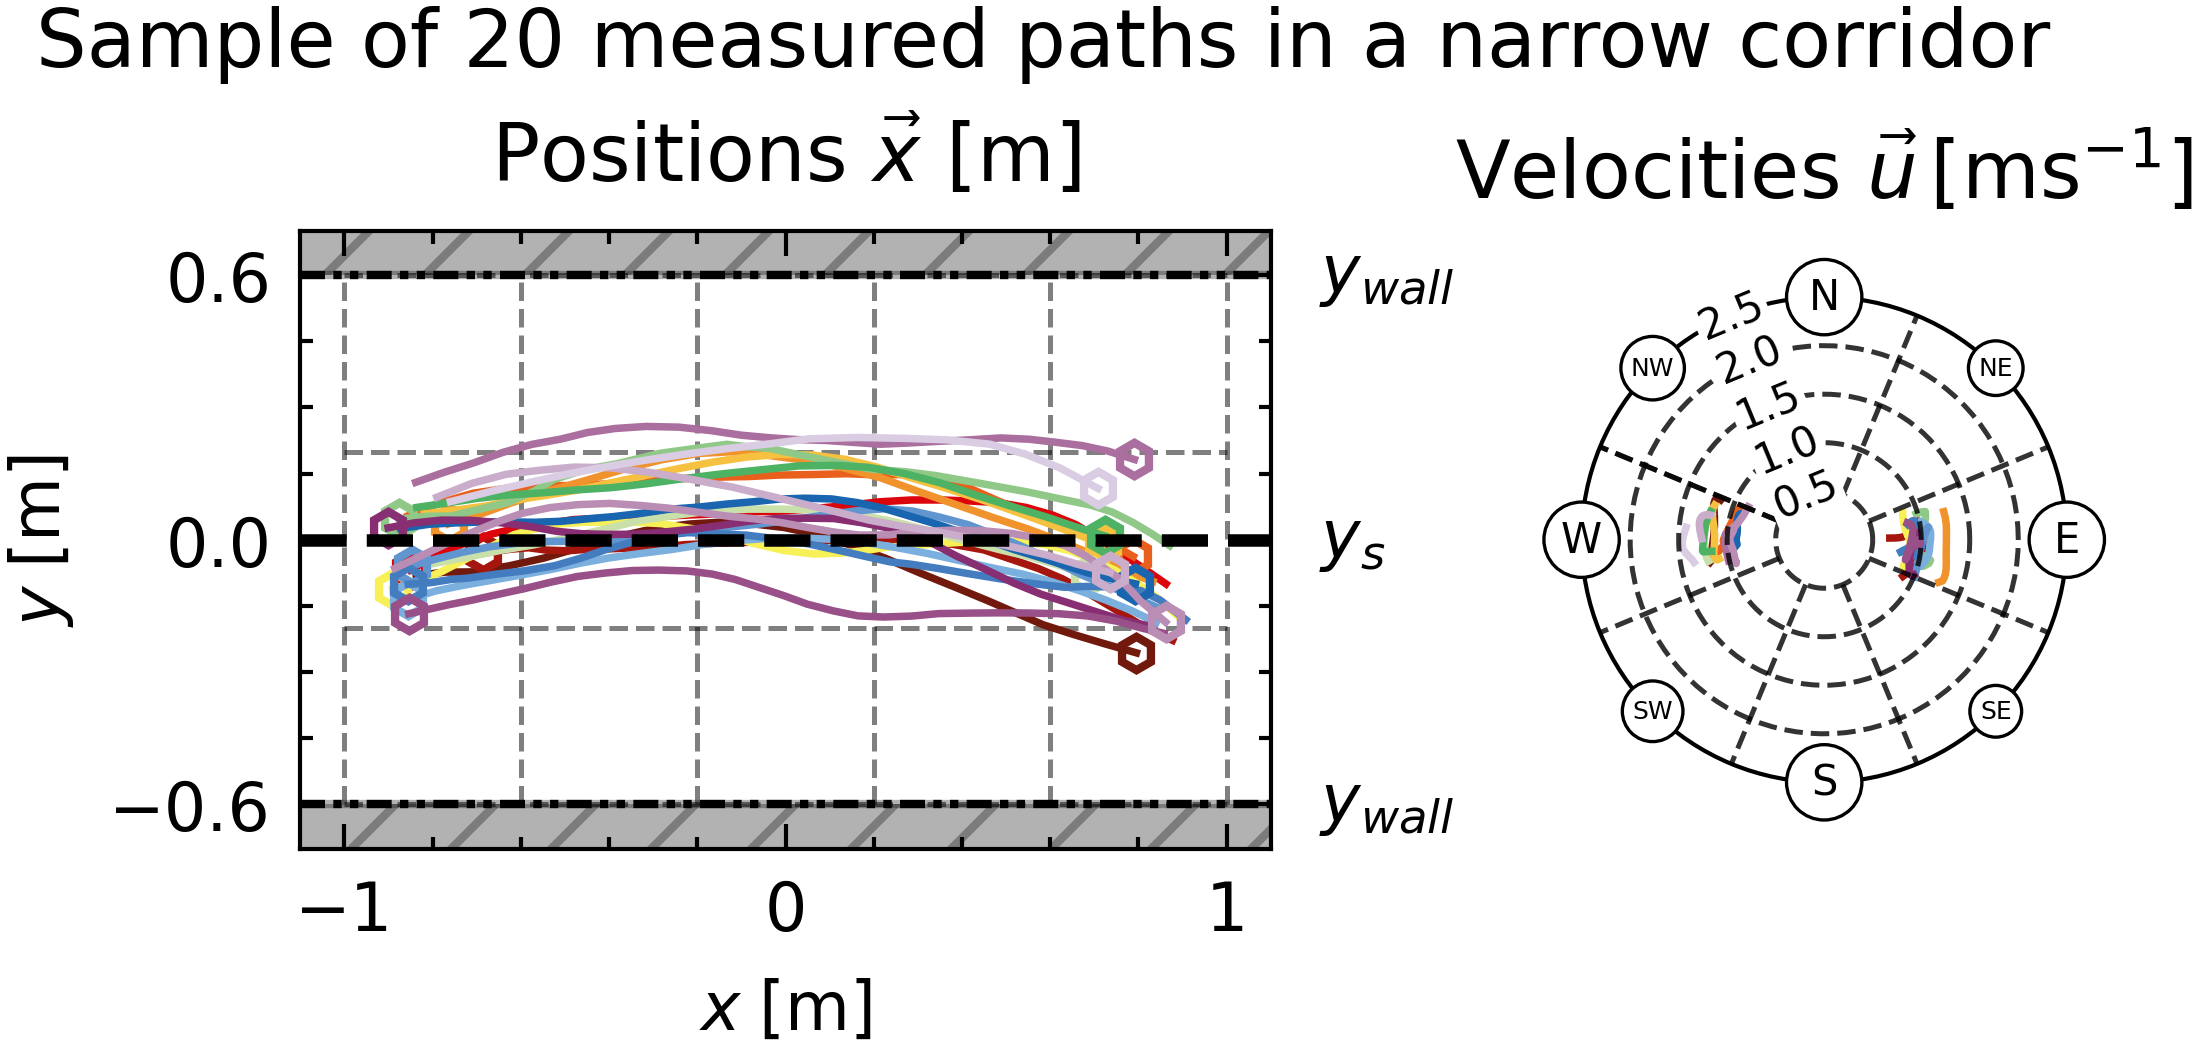

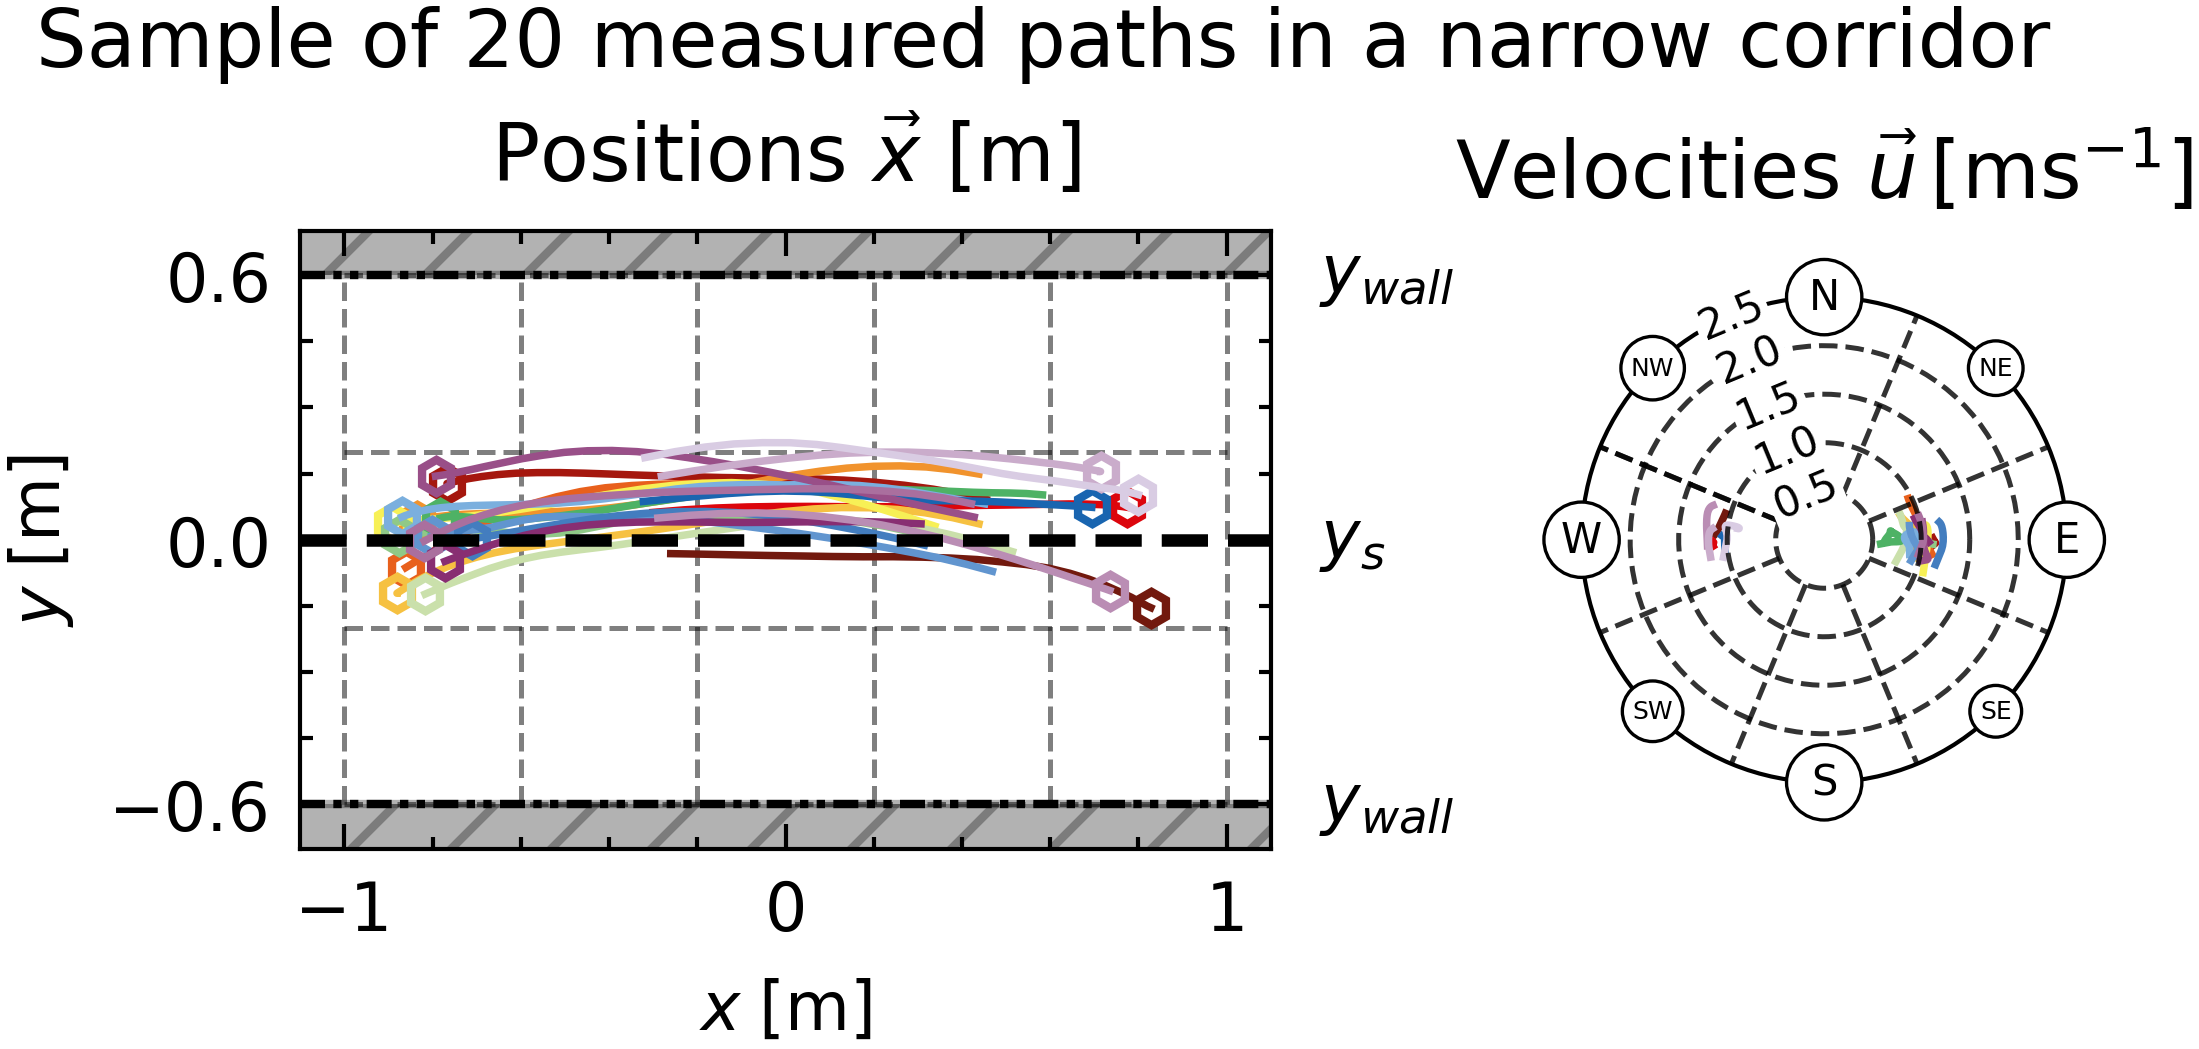

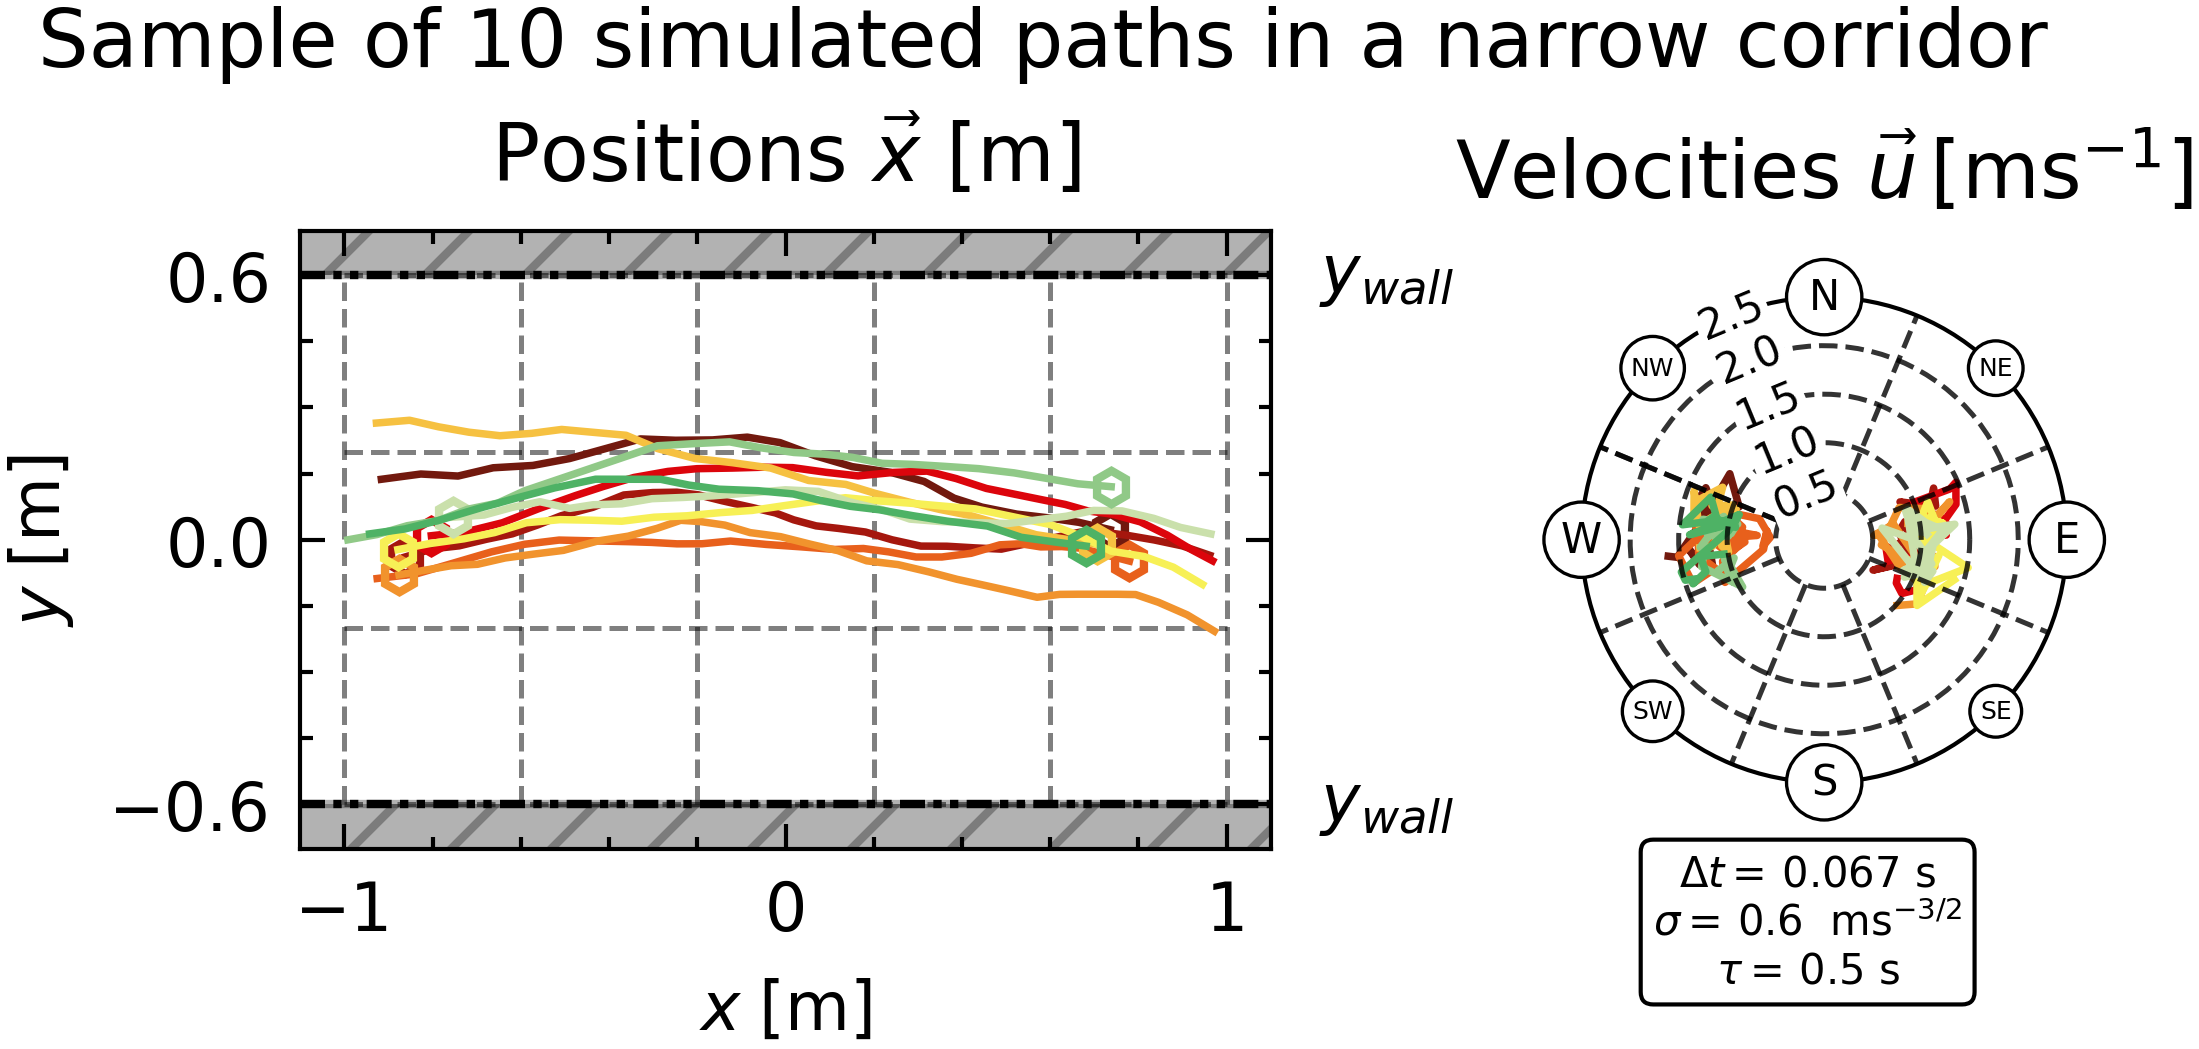

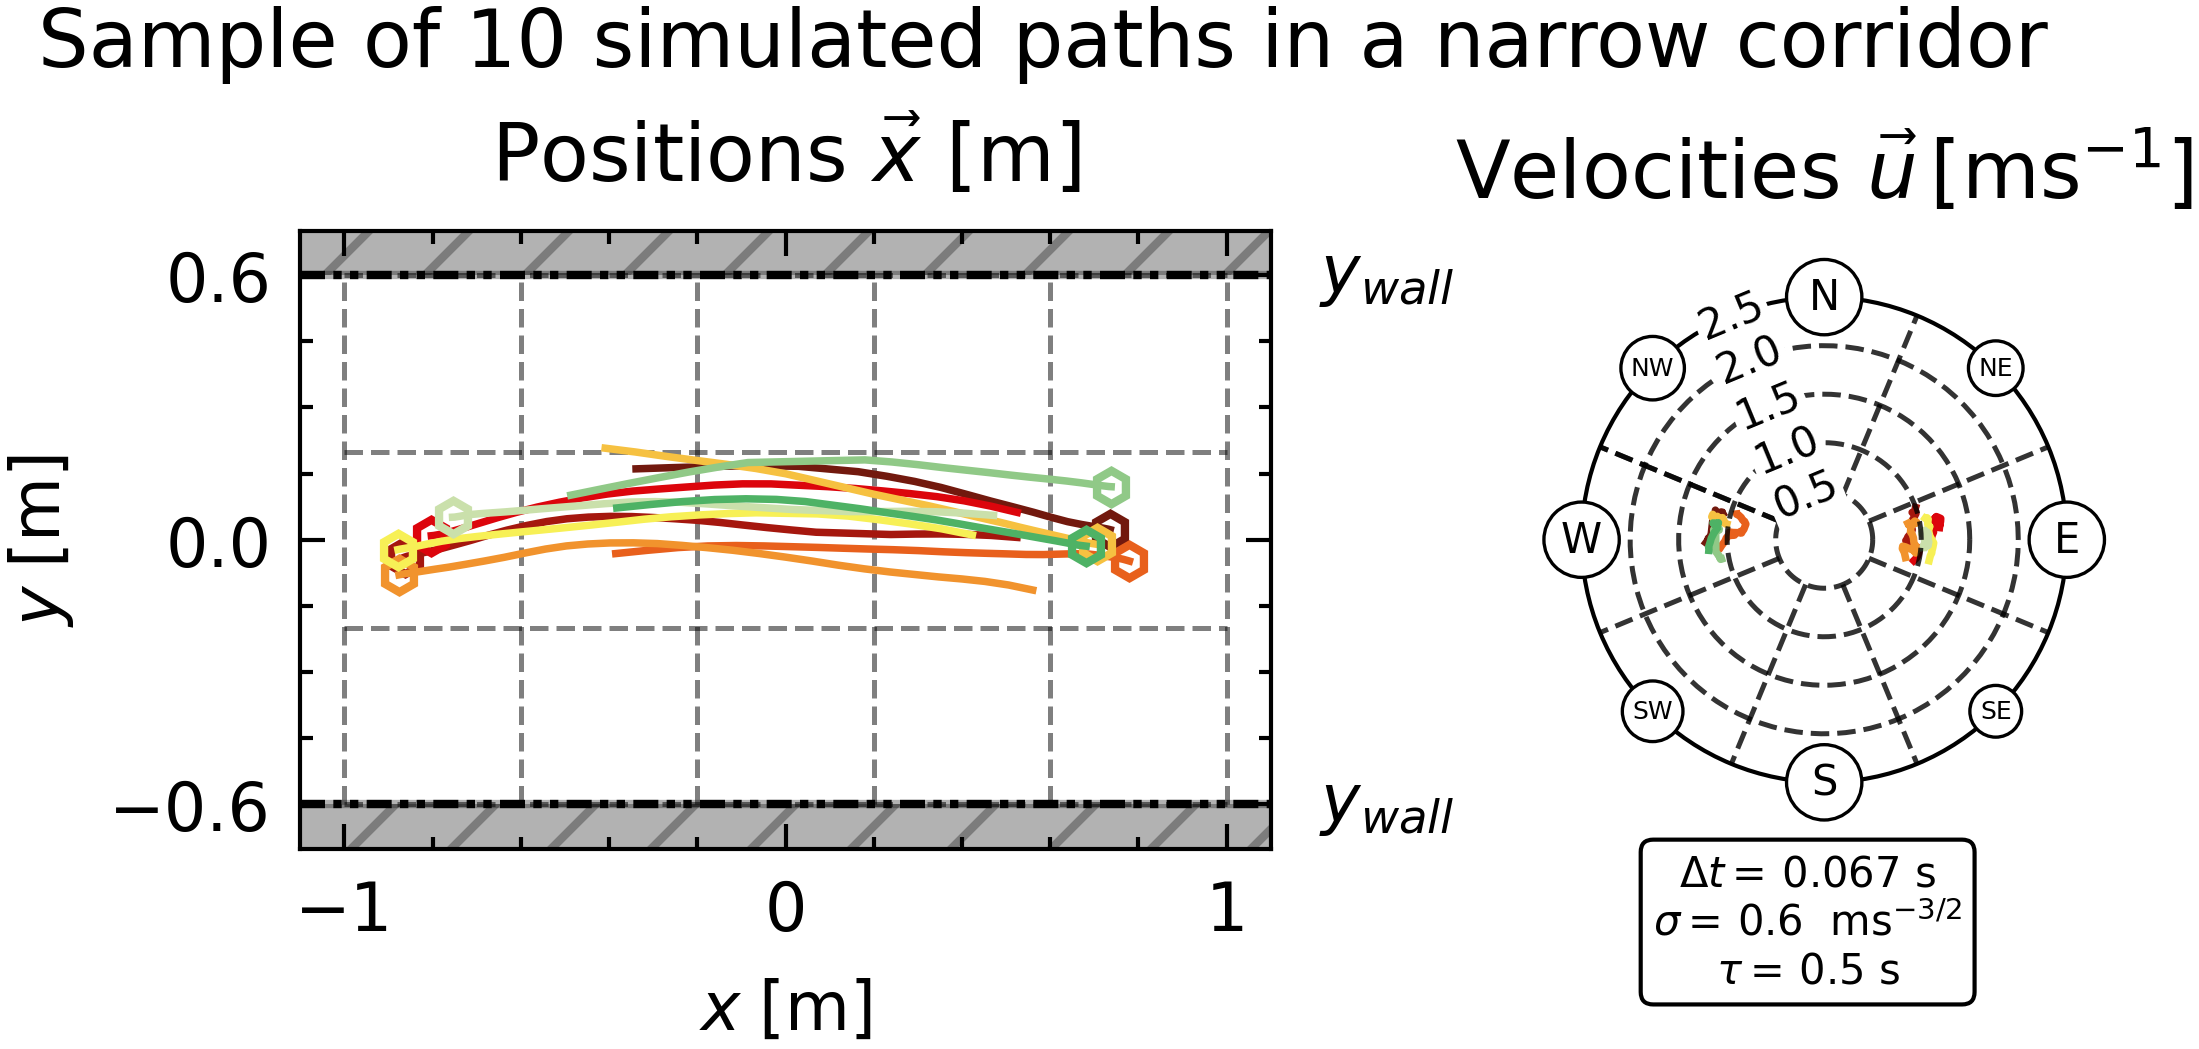

INFO:matplotlib.mathtext:Substituting symbol P from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol P from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol P from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol P from STIXGeneral


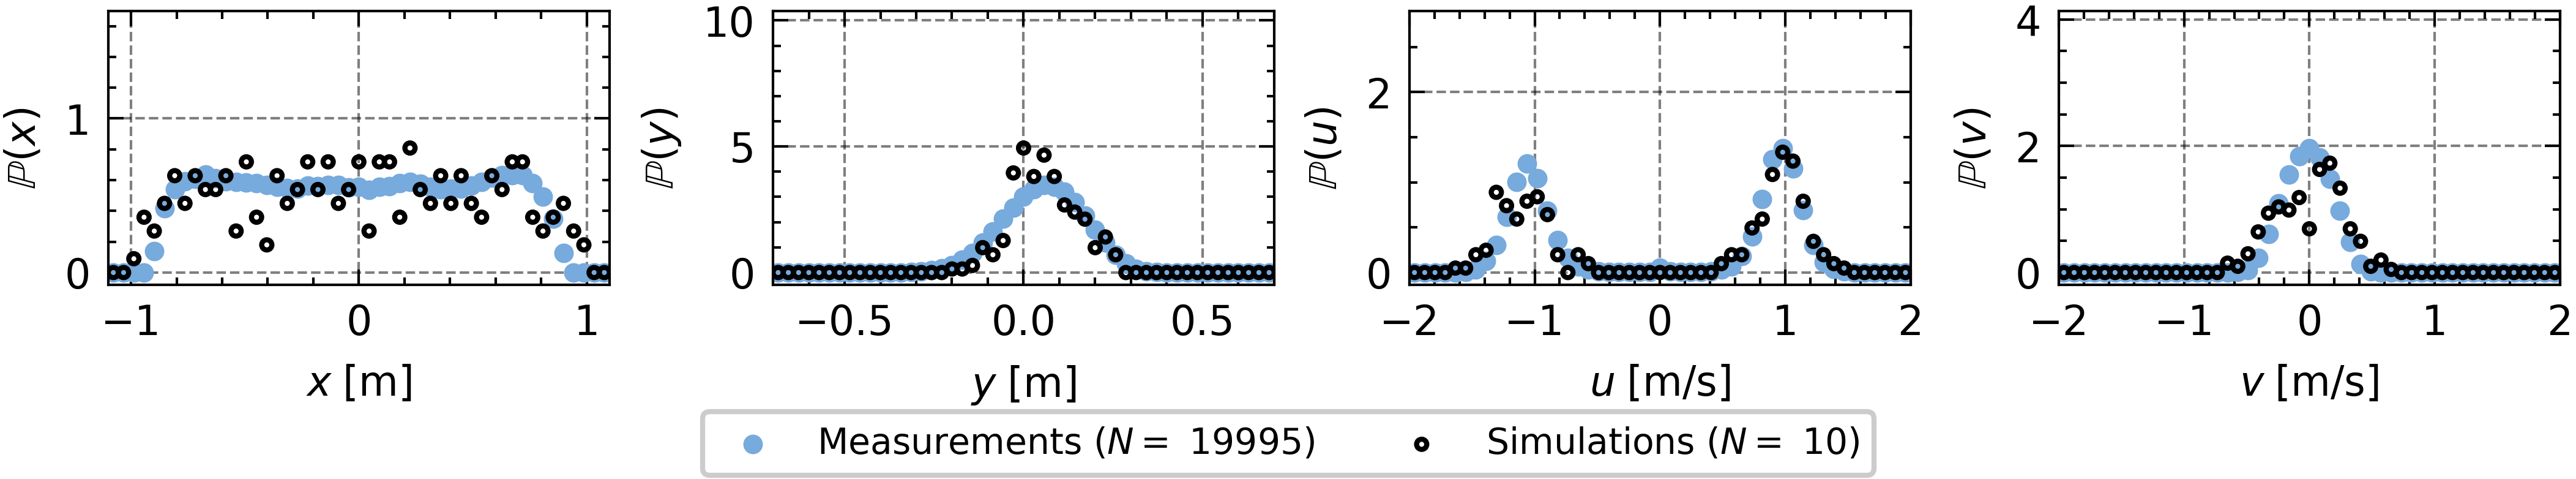

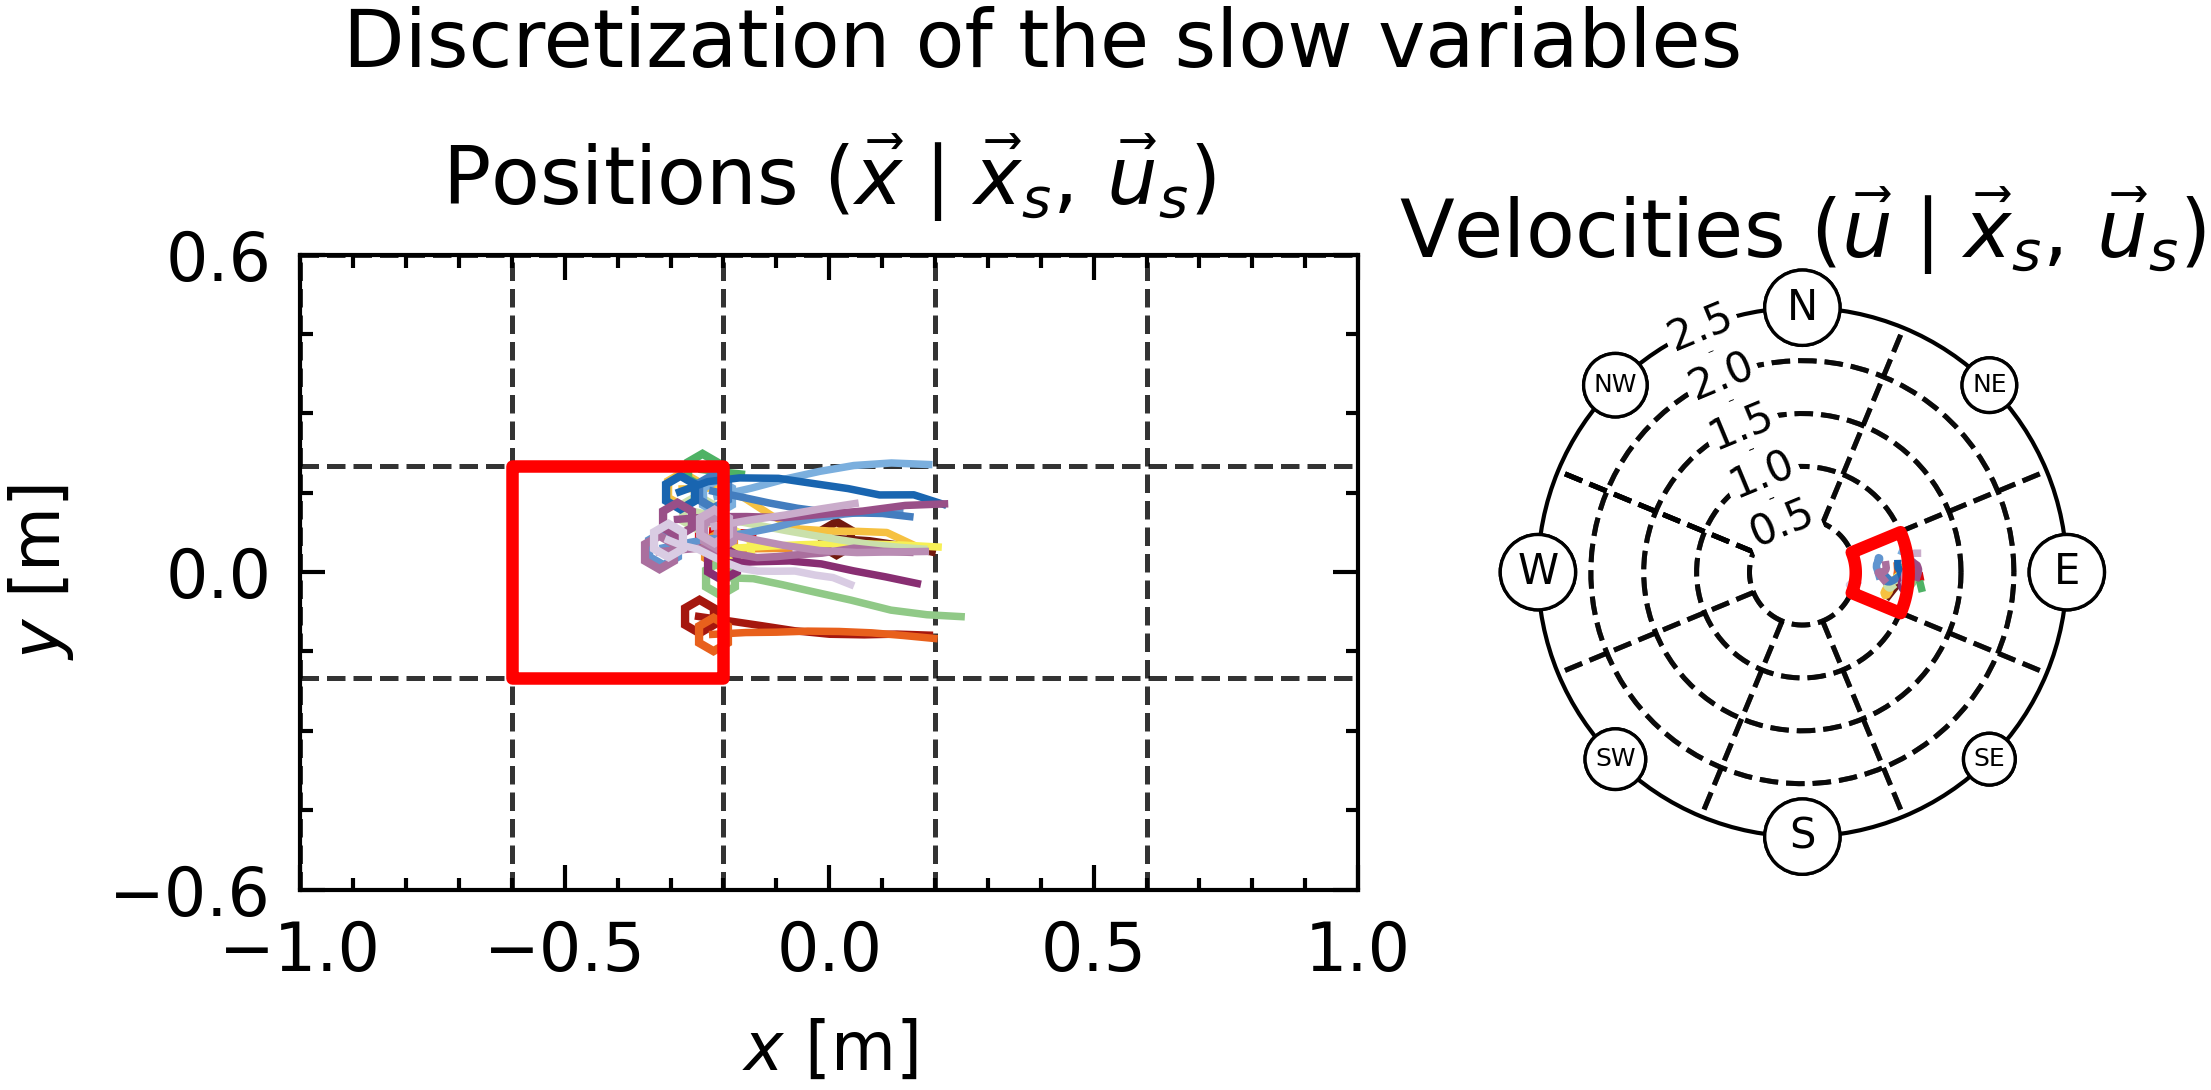

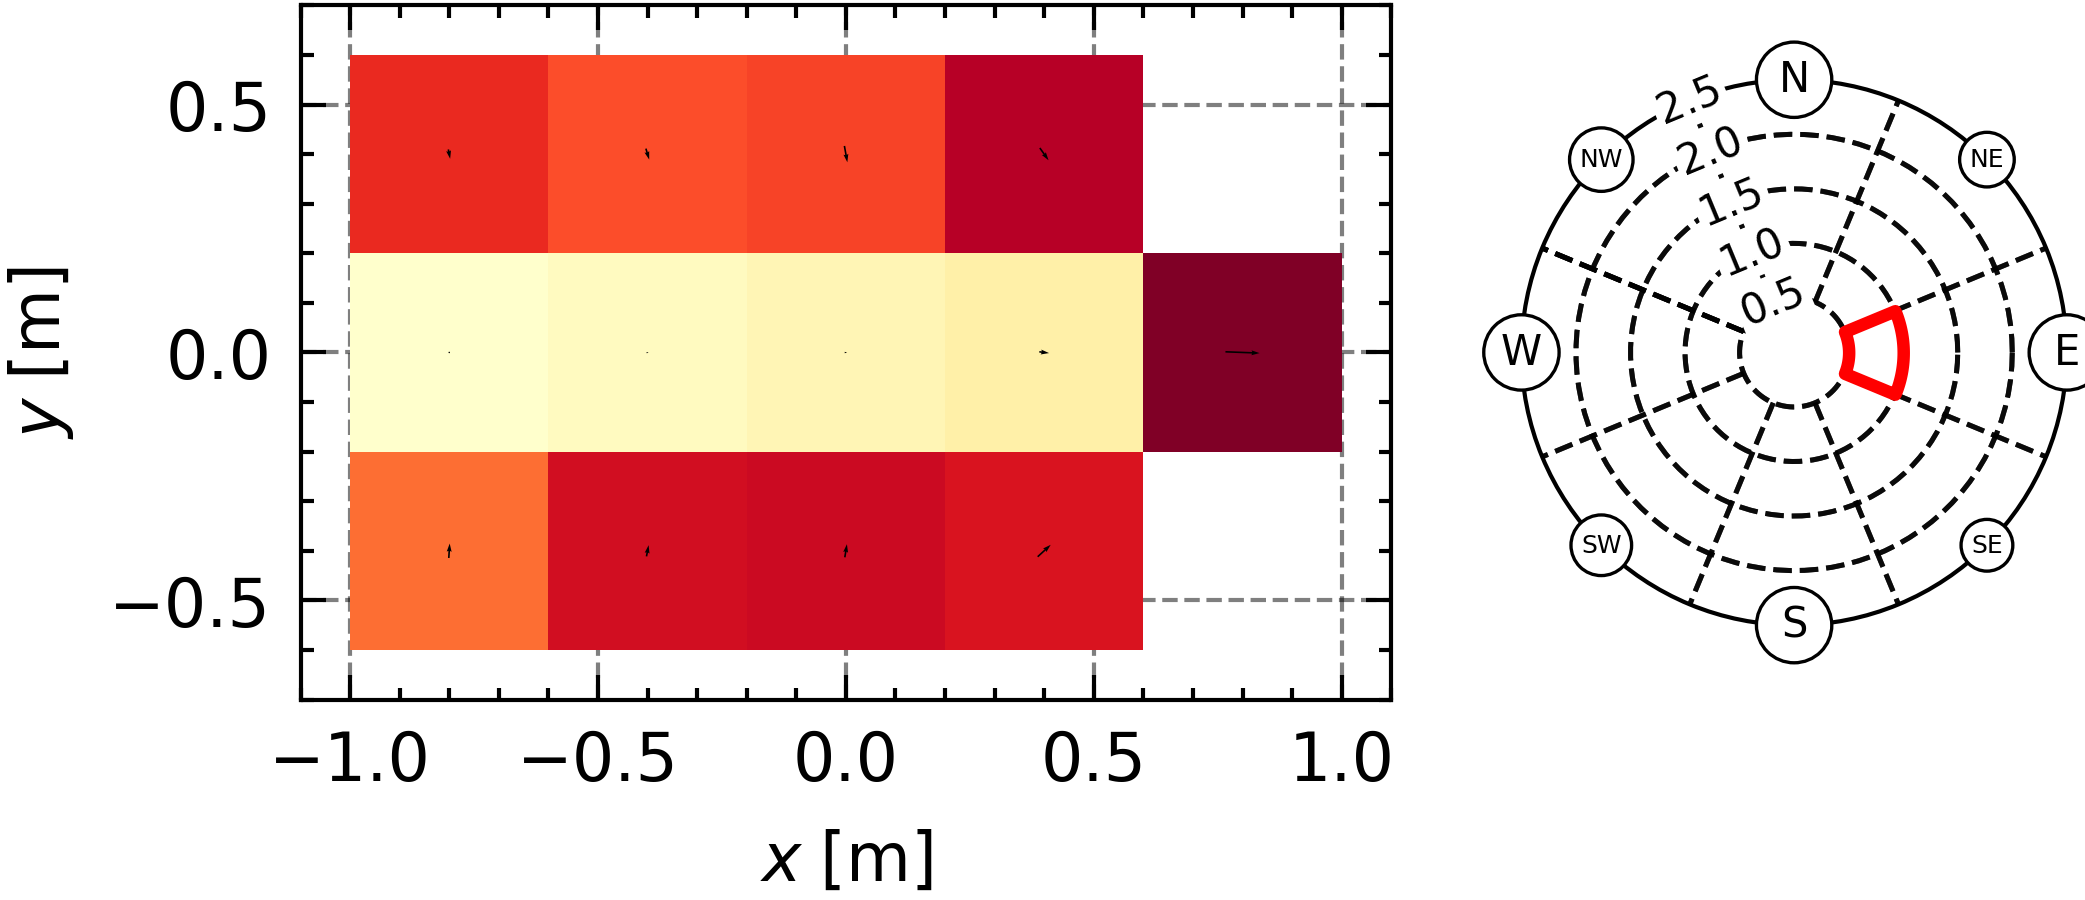

In [11]:
from physped.processing_pipelines import plot_figures
plot_figures(config)